### Gaussian mixture models:
GMM expands on two of the failings of k-means:
+ lack of flexibility in the cluster shape. It always uses a circle/sphere with radios from the mean of the cluster to the furthest point.
+ No probabilistic cluster assignments. 

Sometimes you can avoid the first issue by using PCA or some other form of dimensionality reduction, but you're not guaranteed that a reduction will yield a shape more like a circle/sphere. 

Gaussian mixture models improve on these shortcomings by:
+ Measuring uncertainty in cluster assignment by using distances of each point to *all* cluster centers, not just the closest.
+ Using an ellipses cluster boundary instead of circle. 

GMM idea: find a mixture of multi-dimensional Gaussian probability distributions to best model a dataset.

In this sense, they can be used just like k-means to find clusters. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [7]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

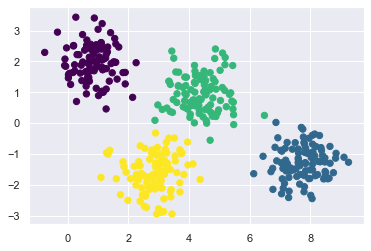

In [6]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Because this is a probability estimate under the hood, we can access the probability for each point using:

predict_proba() --> [n_samples, m_clusters] 

measuring the probability that any point belongs to a cluster.

In [10]:
probs = gmm.predict_proba(X)
print(probs[:10].round(2))

[[0.   0.46 0.54 0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.99 0.01]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]]


For a more interesting graph we can scale the size of each point by this probability to see where the model was most uncertain.

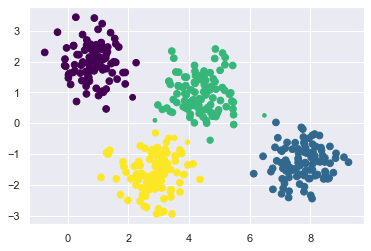

In [15]:
size = 45 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)

GM uses an expectation-maximization approach which generally follows:

1) Choose a starting place for location and shape.

2) Repeat until converged:
    + Expectation: for each point, find weights encoding the probability of membership in each cluster
    + Maximization: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights.
    
The result of this method is that each point is associated with a smooth gaussian curve and not a hard lined circle.
However, this can sometimes miss the global optimum, so multiple random initializations are used.

In [19]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

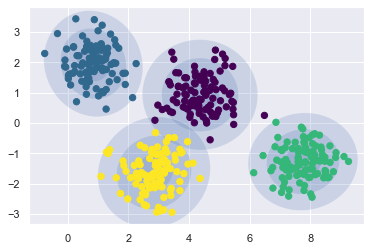

In [20]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

But this wouldn't be too differenct from k-means except we'd have an idea of the probability. However if we had a stretched dataset:

In [21]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

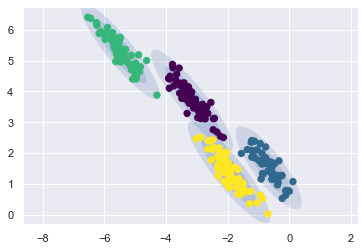

In [25]:
plot_gmm(gmm, X_stretched[:250])

### Covariance types:
The covariance_type hyperparameter of the GM determines the degrees of freedom in the shape for each cluster (orientation of cluster shape). It can be spherical, inline with the axes, or full, which does a best fit, but more computationally expensive. 

### GMM as density estimation.
Even though it's commonly considered a clustering algorithm, fundamentally it does *density estimation*. This means the result of fitting a GM model to some data is a generative probabilistic model *describing the distribution* of the data.

Let's consider a more complicated dataset:

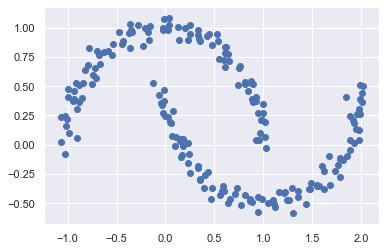

In [26]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we fit a two-component GMM and intend to use it for clustering, the result would be enlightening:

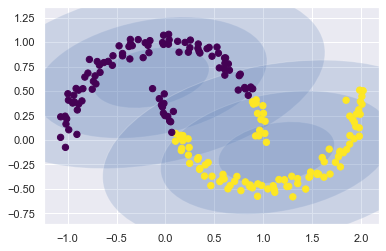

In [28]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Not very helpful. However, if we use more components and don't bother with the labeling:

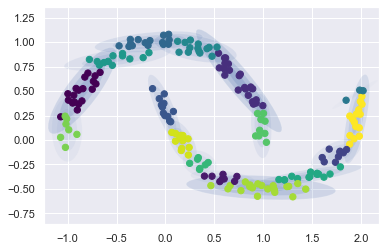

In [30]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=True)

By using more components, and not regarding the labeling (can turn to False), we lost the ability to have any meaningful speration of clusters, but we now have a means of modelling the *overall distribution* of the input data.

This is now a generative model that gives us a way to create *new* data that is distributed similarily to the input data.

If we wanted more points in our moon dataset:

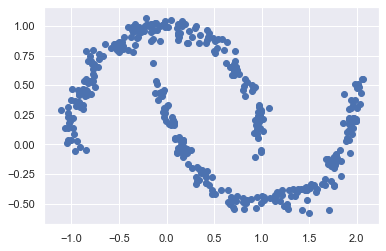

In [43]:
X_gen = gmm16.sample(400)
X_gen_vals = X_gen[0]
plt.scatter(X_gen_vals[:,0], X_gen_vals[:,1])

We added twice as many data points to our dataset! All generated from the 16 component GMM!

GMM is a convenient and flexible way of modeling an arbitrary multi-dimensional distribution of data.

This seems like it is really powerful... There are a few things to take into consideration though:

### How to choose the number of components:
To best use GM as a generative model, we need to make sure we use the best number of components for the input data set. One approach is to evaluate the *likelihood* of the data under the model using cross validation to avoid overfitting. We can also use some analytic criterion like Akaike Information Criterion (AIC). Given a collection of models for the data, AIC estimates the quality of each model relative to each of the other models. This provides a means for model selection.
There is also a Bayesian Information Criterion (BIC) which operates in a similar way. 

From a set of candidate models we want to select the model that minimizes the information loss. We cannot choose with certainty, but we can minimize the estimated information loss.

When fitting models, it is possible to increase the likelihood by adding parameters, but doing so may result in overfitting. Both BIC and AIC attempt to resolve this problem by introducing a penalty term for the number of parameters in the model. The penalty term is larger in BIC than in AIC. 

In both AIC and BIC, we want to pick the model with the minimum value.

Let's look at AIC and BIC for models with varying numbers of components: 

In [45]:
n_components = np.arange(1, 40)
# 40 models with 1-40 number of components:
gm_models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]

Text(0.5, 0, 'n_components')

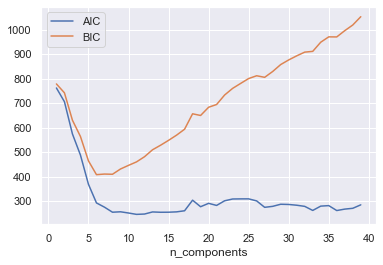

In [47]:
plt.plot(n_components, [model.aic(Xmoon) for model in gm_models], label='AIC')
plt.plot(n_components, [model.bic(Xmoon) for model in gm_models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The optimal number of components/clusters is the one that minimizes the AIC or BIC, depending on which you want to use. BIC tends to reccomend a simpler model (possibly due to the larger penalty term on the number of parameters). 

This choice of number of components measures how well GMM works as a *density estimator*, not how well it works as a *clustering algorithm*. Think of GMM primarily as a *density estimator*, and use it for clustering sparingly. 

### Generating data:
Now that we have an idea for optimal number of components, we can a build a model using that parameter and generate some new data:

In [48]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [54]:
digits.data[0] # each digit is a len 64 narray.

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

~1800 digits in 65 dimensional space (64 features...). 

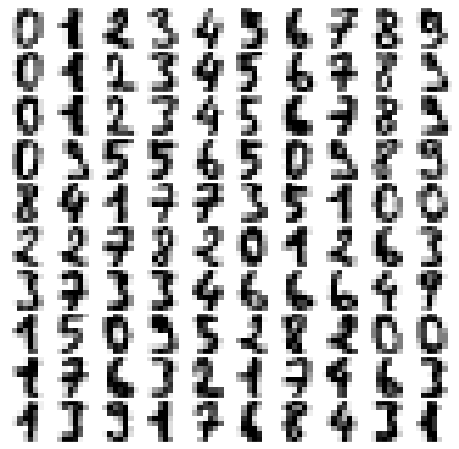

In [76]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        #axi.text(0.05, 0.05, str(digits.target[i]),transform=axi.transAxes, color='green')
        im.set_clim(0, 16)
plot_digits(digits.data)


GMM will have some trouble converging with 64 dimensions, so we'll use PCA to reduce dimensionality while keeping as much variance as possible on the projected data:

In [61]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True) # Here n_components controls the variance
pca_digits = pca.fit_transform(digits.data)
pca_digits.shape

(1797, 41)

We now have a dataset in 'PCA' space of 41 dimensions, almost a 1/3 reduction of the features with almost no information loss.

Now we need to get an idea of how many components to use for the GM.

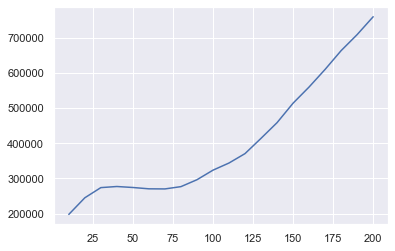

In [63]:
n_components = np.arange(10, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(pca_digits).bic(pca_digits) for model in models]
plt.plot(n_components, aics)

Weird issues, way off from book for both AIC and BIC. BIC says somewhere in the tens and AIC was somewhere around 120.
Let's just see what happens when we generate data for both!

In [64]:
gmm_10 = GaussianMixture(n_components=10, covariance_type='full', random_state=0)
gmm_110 = GaussianMixture(n_components=110, covariance_type='full', random_state=0)

In [65]:
gmm_10.fit(pca_digits)
gmm_110.fit(pca_digits)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=110, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [67]:
print(gmm_10.converged_, gmm_110.converged_)

True True


Now we'll use each model to generate some new data, and plot that data to see what it looks like. 

In [72]:
data_gmm10 = gmm_10.sample(100)
data_gmm110 = gmm_110.sample(100)
data_gmm10[0].shape

(100, 41)

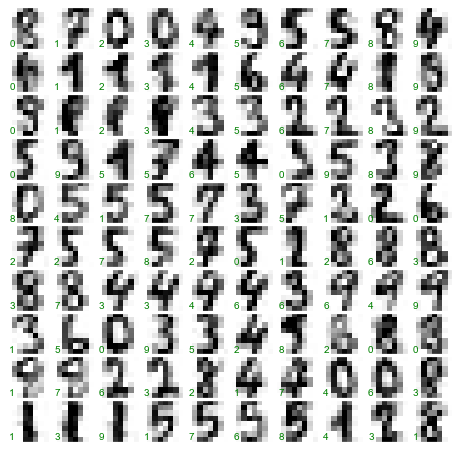

In [75]:
digits_new = pca.inverse_transform(data_gmm110[0])
plot_digits(digits_new)